In [1]:
import numpy
import matplotlib.pyplot as plt 
import pandas
import mglearn
import scipy

import sklearn
import sklearn.ensemble              # import seperatley otherwise sub module won't be imported
import sklearn.neural_network        # import seperatley otherwise sub module won't be imported
from sklearn.cluster import KMeans
import sklearn.feature_selection

import graphviz
import mpl_toolkits.mplot3d as plt3dd

import datetime

In [4]:
path = r"Data\Citibike-2015-Aug\citibike.csv";

citibike = pandas.read_csv(path);
citibike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,3117,8/1/2015 01:19:15,8/1/2015 02:11:12,301,E 2 St & Avenue B,40.722174,-73.983688,301,E 2 St & Avenue B,40.722174,-73.983688,18070,Subscriber,1986.0,1
1,690,8/1/2015 01:27:30,8/1/2015 01:39:00,301,E 2 St & Avenue B,40.722174,-73.983688,349,Rivington St & Ridge St,40.718502,-73.983299,19699,Subscriber,1985.0,1
2,727,8/1/2015 01:38:49,8/1/2015 01:50:57,301,E 2 St & Avenue B,40.722174,-73.983688,2010,Grand St & Greene St,40.721655,-74.002347,20953,Subscriber,1982.0,1
3,698,8/1/2015 06:06:41,8/1/2015 06:18:20,301,E 2 St & Avenue B,40.722174,-73.983688,527,E 33 St & 2 Ave,40.744023,-73.976056,23566,Subscriber,1976.0,1
4,351,8/1/2015 06:24:29,8/1/2015 06:30:21,301,E 2 St & Avenue B,40.722174,-73.983688,250,Lafayette St & Jersey St,40.724561,-73.995653,17545,Subscriber,1959.0,1


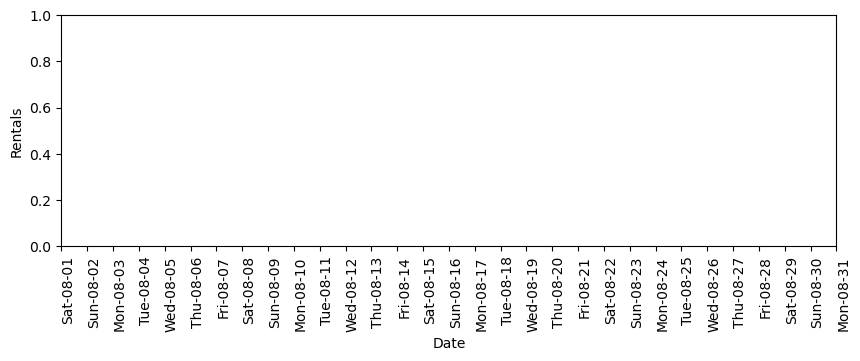

In [47]:
plt.figure(figsize=(10,3));


start = '8/1/2015 00:00:04';  #citibike.starttime.min();
end = '8/31/2015 23:59:59' #citibike.starttime.max();
xticks = pandas.date_range(start=start, end=end, freq="D");
plt.xticks(range(0,len(xticks)), xticks.strftime("%a-%m-%d"), rotation=90, ha="left");
plt.xlabel("Date");
plt.ylabel("Rentals");